# 化学・物理分野と機械学習

化学の分野でも機械学習を使うことはどんどん盛んになっています。ケモインフォマティクスやマテリアルインフォマティクスという言葉を聞いた人もいるでしょう。分子や物質に対して、先程のボストンデータセットのように、性質を決めそうな因子をまとめたデータを作る→そのデータを元に性能を予測して、望ましい分子や物質を探そうといったことが行われています。

私は物理系が専門なので、化学側はあまり詳しくないのですが、ケモインフォマティクス分野での代表的なデータセットが[QM9](https://www.nature.com/articles/sdata201422),ケモインフォマティクス用のデータ処理一式のライブラリが[RDKit](https://www.rdkit.org/)のようですね。

RDKitを使って分子の情報を機械学習モデルにつかえるデータに変換する方法などは、この資料が非常に参考になりそうです。
https://www.kaggle.com/code/vladislavkisin/tutorial-ml-in-chemistry-research-rdkit-mol2vec/notebook

データセットや深層学習モデル一式が揃ったライブラリとしては`Deepchem` https://github.com/deepchem/deepchem があります。これを用いると、さまざまなデータセットを取り込んで、SMILESという分子構造の表現形式から、機械学習モデルに使えるデータに変換する一連の作業を手軽にすすめることができます。

すべてDeepChemを使うチュートリアルは　https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Introduction_to_Gaussian_Processes.ipynb　
にありますが、何をやっているかStep by Stepで見るために少し直接的なことを試してみましょう。

In [86]:
import numpy as np
np.random.seed(123)
import tensorflow as tf
tf.random.set_seed(123)
import deepchem as dc




In [87]:

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

import numpy as np
import matplotlib.pyplot as plt

BACEデータセットというのはβ-セクレターゼ1という酵素の阻害活性を持つ分子のデータセットで、1513個の分子の情報が含まれます。

分子の特徴をExtended Connectivity Fingerprint(ECFP)と呼ばれる方法で記述します。

In [88]:
tasks, datasets, transformers = dc.molnet.load_bace_regression(featurizer='ecfp', splitter='random')
train_dataset, valid_dataset, test_dataset = datasets

データとして持っているのは薬理活性です

In [89]:
tasks

['pIC50']

処理して出てくるdatasetには学習データ、検証データ、テストデータのブロックがあります

In [90]:
train_dataset

<DiskDataset X.shape: (1210, 1024), y.shape: (1210, 1), w.shape: (1210, 1), task_names: ['pIC50']>

In [91]:
valid_dataset

<DiskDataset X.shape: (151, 1024), y.shape: (151, 1), w.shape: (151, 1), ids: ['O(C(=O)C1[NH2+]CC2(C1)c1c(NC2=O)cccc1)C1CCN(CC1)C(=O)C'
 'Clc1cc2nc(n(c2cc1)C(CC(=O)NC(C(=O)[O-])COC(C)(C)C)CC)N'
 's1cc(cc1C(=O)CC)[C@]1(N=C(N)N(C)C1=O)c1cc(ccc1)-c1cccnc1F' ...
 'Fc1ccc(cc1OCCCF)[C@]1(N=C(N)N(C)C1=O)c1ccc(OC(F)F)cc1'
 'Fc1cc(ccc1F)CC(NC(=O)C)C(O)C[NH2+]C1CC2(Oc3ncc(cc13)CC(C)(C)C)CCC2'
 'O=C1N(C)C(=NC(C1)(C)C1CC1c1cc(ccc1)-c1cc(ccc1)CO)N'], task_names: ['pIC50']>

In [92]:
test_dataset

<DiskDataset X.shape: (152, 1024), y.shape: (152, 1), w.shape: (152, 1), ids: ['O1CC(NC(=O)c2cc(cc(c2)C(=O)N[C@@H](C\\C=C\\C1)c1ccccc1)C)C(O)C[NH2+]Cc1cc(ccc1)C(C)C'
 'S(=O)(=O)(N(C)c1cc(cc(c1)C(OCC([NH2+]C)(Cc1ccccc1)CO)=O)C(=O)NC(C)c1ccc(F)cc1)C'
 's1cc(cc1C1(N=C(N)N(C)C(=O)C1)C)-c1cc(ccc1)C#N' ...
 'S(=O)(=O)(N(Cc1ccccc1)C)c1cc(ccc1)C(=O)NC(Cc1ccccc1)C(O)C[NH2+]C(C(=O)NC1CCCCC1)C'
 'S1(=O)(=O)CC(Cc2cc(CC)c(O)cc2)C(O)C([NH2+]Cc2cc(ccc2)C(C)C)C1'
 'Clc1cc2nc(n(c2cc1)[C@H](CC(=O)NCC1CCCCC1)CC)N'], task_names: ['pIC50']>

それぞれのXには1024次元のベクトルで記述子が収められており、ｙにはそれぞれの分子の薬理活性が入っています

データを読み込む段階で、正規化がされておりもともとの値に戻すためには、transformersと指定されている3番目のデータを使います

In [93]:
transformers[0].untransform(train_dataset.y)

array([[6.0268722],
       [7.9208188],
       [5.5528421],
       ...,
       [4.4685211],
       [5.8996296],
       [6.7958798]])

In [94]:

from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fit trained model
model.fit(train_dataset.X,train_dataset.y)
train_score=model.score(train_dataset.X,train_dataset.y)
test_score=model.score(test_dataset.X,test_dataset.y)

train_score, test_score


(0.9778751773788851, -24.89723785522296)

線形モデルだと全然むりですね…

ガウス過程回帰を試してみましょう

In [95]:
output_variance = 0.38974570882583015
length_scale = 5.375387643239208
noise_level = 0.0016265333497286342
kernel = output_variance**2 * RBF(length_scale=length_scale, length_scale_bounds='fixed') + WhiteKernel(noise_level=noise_level, noise_level_bounds='fixed')
alpha = 4.989499481123432e-09

sklearn_gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha)
sklearn_gpr.fit(train_dataset.X,train_dataset.y)

GaussianProcessRegressor(alpha=4.989499481123432e-09,
                         kernel=0.39**2 * RBF(length_scale=5.38) + WhiteKernel(noise_level=0.00163))

In [96]:
sklearn_gpr.score(train_dataset.X,train_dataset.y)

0.9885198964788846

In [97]:
sklearn_gpr.score(test_dataset.X,test_dataset.y)

0.7366611436254847

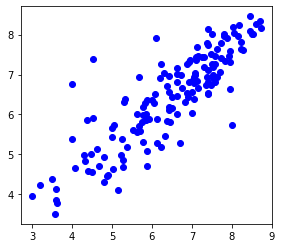

In [98]:
y_pred=sklearn_gpr.predict(test_dataset.X)

y_meas_test = transformers[0].untransform(test_dataset.y)
y_pred_test=transformers[0].untransform(y_pred)

plt.axes().set_aspect('equal')
plt.scatter(y_meas_test,y_pred_test,c='blue')

他のschikit-learnのモデルではどんな結果になるでしょうか？
https://sites.google.com/g.chuo-u.ac.jp/spec-group/ml-challenges　
などを参考に試してみましょう。